# 기업 시장/재무 데이터 분석 

## 1) 기업 종목 코드 크롤링 

### 1-1) 한국거래소 데이터를 바로 크롤링

밑의 코드를 사용하면 현재 한국거래소에 상장되어있는 기업들의 기업명, 종목코드를 간편하게 수집 가능.  
하지만 이 방법으로는 업종코드를 따로 붙여야함.  

[ 참고: http://excelsior-cjh.tistory.com/109 ] 

In [13]:
# 필요한 모듈 임포트 

import re
from datetime import datetime
import pandas as pd
import requests
from bs4 import BeautifulSoup
from scipy import stats, polyval

In [14]:
# 한국거래소에서 상장기업정보 받기 

import pandas as pd

code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format)
code_df = code_df[['회사명','종목코드']]
code_df = code_df.rename(columns={'회사명':'name','종목코드':'code'})

code_df.head()

,name,code
0,CJ,001040
1,HDC,012630
2,HSD엔진,082740
3,KG케미칼,001390
4,LG이노텍,011070


### 1-2) 한국거래소에서 csv 파일 다운로드 

한국거래소에서 다운받은 상장기업정보 csv파일을 dataframe으로 읽어옴.  
업종코드가 붙어있어서 편하지만, 직접 csv파일을 다운받아야하는 번거로움.  

In [15]:
# 한국거래소에서 다운받은 csv파일 데이터프레임으로 저장하기 
#-*- coding: utf-8 -*-

corp_df = pd.read_csv('corp_code2.csv')

# 종목코드 6자리 문자열로 맞추기 

adj_code = []

for i in corp_df.code:
     adj_code.append(str(i).zfill(6))

corp_df.code = adj_code

# csv 다운로드 

corp_df.to_csv('corp_df.csv')

In [16]:
corp_df.head()

,code,name,cate_code,cate_name
0,060310,3S,32902,특수 목적용 기계 제조업
1,095570,AJ네트웍스,147603,산업용 기계 및 장비 임대업
2,068400,AJ렌터카,147601,운송장비 임대업
3,006840,AK홀딩스,116409,기타 금융업
4,054620,APS홀딩스,116409,기타 금융업


## 2) 기업 재무 데이터 크롤링 

네이버 금융 페이지 웹크롤링 

[ 참고: https://financedata.github.io/posts/naver-finance-finstate-crawling.html ]



In [17]:
# 컬럼명 정리 함수 생성 

def get_date_str(s):
    date_str = ''
    r = re.search("\d{4}/\d{2}", s)
    if r:
        date_str = r.group()
        date_str = date_str.replace('/', '-')
    return date_str

In [18]:
def get_finstate_naver(code, fin_type='0', freq_type='Q'):

    # 종목코드에 따른 url 생성 
    url_tmpl = 'http://companyinfo.stock.naver.com/v1/company/ajax/cF1001.aspx?' \
                   'cmp_cd=%s&fin_typ=%s&freq_typ=%s'
    url = url_tmpl % (code, fin_type, freq_type)

    # 재무정보 크롤링 
    dfs = pd.read_html(url, encoding="utf-8")
    df = dfs[0]
    df = df.set_index('주요재무정보')
    
    # 컬럼명 정리 
    cols = list(df.columns)
    cols = [get_date_str(cols[i][1]) for i in range(len(cols))]
    df.columns = cols
    df = df.ix[:, :-1]

    # 전치행렬
    dft = df.T
    
    # 컬럼명 정리 2    
    col = list(dft.columns)
    adj_col = [dft.columns[i][0] for i in range(len(col))]
    dft.columns = adj_col

    # date 데이터타입 변경 
    dft.index = pd.to_datetime(dft.index)

    # remove if index is NaT
    dft = dft[pd.notnull(dft.index)]
#    dft = dft[pd.notnull(dft.매출액)]
    
    # corp_df에서 코드명 컬럼 가져오기 
    dft['code'] = code
    
    # 컬럼명 영어로 변경 
    dft = dft.rename(columns={'매출액': 'sales', 
                              '영업이익':'operating revenue', 
                              '영업이익(발표기준)':'operating revenue(announced)', 
                              '세전계속사업이익':'earnings before tax', 
                              '당기순이익':'net income', 
                              '당기순이익(지배)':'net income attribuable to owners' ,     
                              '당기순이익(비지배)':'net income attributable to non-controlling interests', 
                              '자산총계':'assets',
                              '부채총계':'liabilities', 
                              '자본총계':'equity', 
                              '자본총계(지배)':'owners equity', 
                              '자본총계(비지배)':'non-controlling equity', 
                              '자본금':'capital stock',
                              '영업활동현금흐름':'cash flows from operating activities',
                              '투자활동현금흐름':'cash flows from investing activities', 
                              '재무활동현금흐름':'cash flows from financing activities', 
                              #'CAPEX', 
                              #'FCF', 
                              '이자발생부채':'interests-bearing liabilities', 
                              '영업이익률':'ratio of operating profit to revenue',
                              '순이익률':'ROS', 
                              'ROE(%)':'ROE', 
                              'ROA(%)':'ROA', 
                              '부채비율':'debt ratio', 
                              '자본유보율':'capital-holding ratio', 
                              'EPS(원)':'EPS', 
                              'PER(배)':'PER',
                              'BPS(원)':'BPS', 
                              'PBR(배)':'PBR', 
                              '현금DPS(원)':'cash DPS', 
                              '현금배당수익률':'cash dividend yield ratio', 
                              '현금배당성향(%)':'cash dividend payout ratio', 
                              '발행주식수(보통주)':'total issued stock',
                              #'code'
                             })
    
    
    return dft


get_finstate_naver('000120')

C:\Users\yeseol\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


,sales,operating revenue,operating revenue(announced),earnings before tax,net income,net income attribuable to owners,net income attributable to non-controlling interests,assets,liabilities,equity,...,capital-holding ratio,EPS,PER,BPS,PBR,cash DPS,cash dividend yield ratio,cash dividend payout ratio,total issued stock,code
2017-06-01,15949.0,511.0,511.0,129.0,44.0,38.0,7.0,54580.0,27468.0,27112.0,...,2449.30,165.0,105.88,133766.0,1.24,NaN,NaN,NaN,22812344.0,000120
2017-09-01,17078.0,619.0,619.0,379.0,245.0,223.0,22.0,56884.0,29305.0,27579.0,...,2468.88,978.0,125.05,135472.0,1.33,NaN,NaN,NaN,22812344.0,000120
2017-12-01,18732.0,626.0,626.0,204.0,108.0,93.0,15.0,63145.0,34873.0,28273.0,...,2476.98,406.0,83.13,136148.0,1.20,NaN,NaN,NaN,22812344.0,000120
2018-03-01,19344.0,600.0,600.0,19.0,-9.0,-38.0,30.0,63089.0,35262.0,27827.0,...,2474.00,-169.0,101.44,134556.0,1.04,NaN,NaN,0.0,22812344.0,000120
2018-06-01,20015.0,453.0,453.0,434.0,348.0,329.0,19.0,72386.0,42464.0,29922.0,...,2514.50,1443.0,51.73,138708.0,0.99,NaN,NaN,0.0,22812344.0,000120
2018-09-01,21351.0,551.0,NaN,226.0,132.0,209.0,NaN,NaN,NaN,NaN,...,NaN,916.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000120
2018-12-01,22414.0,644.0,NaN,294.0,182.0,199.0,NaN,NaN,NaN,NaN,...,NaN,874.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,000120


In [125]:
# 2208개의 상장기업 재무정보 데이터프레임 union join

fin_df = pd.DataFrame()

for i in list(corp_df.code):
    fin_df = pd.concat([fin_df,get_finstate_naver(i)])

C:\Users\yeseol\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


In [21]:
# csv로 저장 

fin_df.to_csv('fin_df.csv', encoding='utf-8') # 다운은 받아지나 csv 열었을 때 한글컬럼명 깨지는 문제  

## 3) 기업 시장 데이터 크롤링 

### 3-1) 야후 모듈 사용하여 일별 시세 크롤링 

하지만 누락되는 데이터가 보여서 코드만 첨부

[ 참고: https://gomjellie.github.io/%ED%8C%8C%EC%9D%B4%EC%8D%AC/pandas/%EC%A3%BC%EC%8B%9D/2017/06/09/pandas-datareader-stock.html ] 



In [ ]:
from pandas_datareader import data
import fix_yahoo_finance as yf
yf.pdr_override()
start_date = '2018-07-01'
tickers = ['067160.KQ', '035420.KS','000660.KS']
afreeca = data.get_data_yahoo(tickers[0], start_date)
naver = data.get_data_yahoo(tickers[1], start_date)
hynix = data.get_data_yahoo(tickers[2], start_date)

naver

### 3-2) 네이버 금융 사이트에서 일별 시세 크롤링 



In [177]:
# 일별시세 크롤링 함수 생성

def get_market_price(code) :
    price_df = pd.DataFrame()
    url_tmpl = 'http://finance.naver.com/item/sise_day.nhn?code=' + str(code)
    for page in range(1,10) : 
        url = url_tmpl + '&page=' + str(page)
        df = pd.read_html(url, header=0)[0]
        price_df = pd.concat([price_df,df])
        price_df = price_df.dropna()
    price_df['code'] = code
    return price_df


get_market_price('054620')
    

,날짜,종가,전일비,시가,고가,저가,거래량,code
1,2018.07.20,5470.0,10.0,5560.0,5560.0,5340.0,65971.0,054620
2,2018.07.19,5480.0,110.0,5610.0,5610.0,5290.0,99363.0,054620
3,2018.07.18,5590.0,10.0,5600.0,5700.0,5470.0,218158.0,054620
4,2018.07.17,5600.0,180.0,5470.0,5670.0,5400.0,272154.0,054620
5,2018.07.16,5420.0,120.0,5250.0,5460.0,5250.0,101006.0,054620
9,2018.07.13,5300.0,10.0,5380.0,5390.0,5250.0,82662.0,054620
10,2018.07.12,5310.0,10.0,5320.0,5370.0,5270.0,116538.0,054620
11,2018.07.11,5320.0,30.0,5290.0,5400.0,5190.0,143747.0,054620
12,2018.07.10,5290.0,40.0,5300.0,5310.0,5170.0,141518.0,054620
13,2018.07.09,5250.0,310.0,4885.0,5720.0,4885.0,858350.0,054620


In [178]:
# 2208개 상장기업 일별시세 합치기 

price_df = pd.DataFrame()

for i in list(corp_df.code) :
    price_df = pd.concat([price_df,get_market_price(i)])

In [180]:
#price_df.to_csv('price_df.csv')

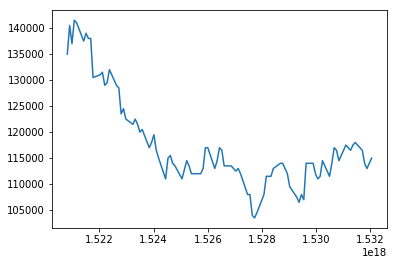

In [291]:
# 일별시세 라인그래프 test

import matplotlib.pylab as plt

print(plt.plot(x, y))

## 4) 재무데이터 변수 가공 

- 크롤링한 재무정보를 활용하여 수익성, 안정성, 성장성, 활동성을 의미하는 재무지표를 생성 
    - 재무지표는 네이버 금융 참고 
    - *현재는 네이버 금융 기업현황에 있는 기본적인 재무지표만 활용하여 변수를 가공하지만, 추후에는 재무상태표, 포괄손익계산서, 현금흐름표 모두 크롤링해서 좀 더 다양한 변수 활용 가능*



![image](https://user-images.githubusercontent.com/28600272/43047480-ae97859a-8e12-11e8-95df-6207bc42278c.png)


In [172]:
#### 성장률 변수를 위해 전기, 당기 재무정보만 사용 

before = '2017-12-01'
after = '2018-03-01'

### 새로 가공한 변수를 담기위한 데이터프레임 생성 

test = pd.DataFrame()
test['code']=corp_df.code


temp_columns1 = ['ratio of operating profit to revenue','ROS','ROE','ROA', # 수익성
                'debt ratio', # 안정성
                'EPS', 'BPS', 'PER', 'EPS', 'PBR', 'cash dividend yield ratio', 'cash dividend payout ratio' ] # 가치지표 
temp_columns2 = ['sales','operating revenue','net income','assets','equity'] # 성장성 
temp_columns3 = ['assets_turnover_ratio'] # 총자산회전율
temp_columns4 = ['equity_turnover_ratio'] # 자기자본회전율

total_temp = temp_columns1+temp_columns2+temp_columns3+temp_columns4

###### 변수 가공 loop


for t in total_temp:        
    temp_list = list()
    if t in temp_columns1:
        for i in test.code: 
            try : 
                temp_list.append(fin_df[fin_df['code']==i][t][after])
            except:
                temp_list.append(0)
        test[t]= temp_list

    elif t in temp_columns2 : 
        for i in test.code:
            try: 
                temp_list.append((fin_df[fin_df['code']==i][t][after]-fin_df[fin_df['code']==i][t][before])/fin_df[fin_df['code']==i][t][before])
            except:
                temp_list.append(0)
        test[str(t+'_qoq')] = temp_list

    elif t in temp_columns3 : 
        for i in test.code:
            try:
                temp_list.append(fin_df[fin_df['code']==i]['sales'][after]/((fin_df[fin_df['code']==i]['assets'][after]+fin_df[fin_df['code']==i]['assets'][before])/2))
            except:
                temp_list.append(0)
        test[t] = temp_list

    elif t in temp_columns4 : 
        for i in test.code:
            try:
                temp_list.append(fin_df[fin_df['code']==i]['sales'][after]/((fin_df[fin_df['code']==i]['equity'][after]+fin_df[fin_df['code']==i]['equity'][before])/2))
            except:
                temp_list.append(0)
        test[t] = temp_list

test.head()

C:\Users\yeseol\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\yeseol\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


,code,ratio of operating profit to revenue,ROS,ROE,ROA,debt ratio,EPS,BPS,PER,PBR,cash dividend yield ratio,cash dividend payout ratio,sales_qoq,operating revenue_qoq,net income_qoq,assets_qoq,equity_qoq,assets_turnover_ratio,equity_turnover_ratio
0,060310,12.70,4.19,-22.67,-12.83,84.68,9.0,671.0,-10.80,2.75,NaN,NaN,0.277778,-3.400000,-1.500000,0.042000,0.010753,0.180215,0.327986
1,095570,3.94,0.10,5.27,0.93,426.47,19.0,6168.0,21.76,1.13,1.2,442.02,-0.002962,-0.298077,-0.951807,0.043251,0.002691,0.160623,0.829154
2,068400,4.79,0.48,5.27,1.03,393.95,35.0,11134.0,17.40,0.89,NaN,0.00,-0.042771,-0.406250,-0.843137,-0.005071,0.002442,0.130289,0.645935
3,006840,6.14,2.87,15.07,6.52,155.61,738.0,54400.0,9.11,1.26,NaN,85.79,0.052103,-0.370495,-0.661039,0.014783,0.014977,0.311526,0.796345
4,054620,30.17,92.07,348.19,167.95,26.47,-1231.0,14966.0,0.18,0.50,NaN,-2.72,-1.625418,-4.111111,-25.571429,-0.109147,-0.036278,-0.076016,-0.100134


In [296]:
########## 분기 하나씩 밀리는 문제 해결 필요 

new_fin_df = new_fin_df.set_index('code')
new_fin_df.head()

,ratio of operating profit to revenue,ROS,ROE,ROA,debt ratio,EPS,BPS,PER,PBR,cash dividend yield ratio,cash dividend payout ratio,sales_qoq,operating revenue_qoq,net income_qoq,assets_qoq,equity_qoq,assets_turnover_ratio,equity_turnover_ratio
code,,,,,,,,,,,,,,,,,,
060310,12.70,4.19,-22.67,-12.83,84.68,9.0,671.0,-10.80,2.75,NaN,NaN,0.277778,-3.400000,-1.500000,0.042000,0.010753,0.180215,0.327986
095570,3.94,0.10,5.27,0.93,426.47,19.0,6168.0,21.76,1.13,1.2,442.02,-0.002962,-0.298077,-0.951807,0.043251,0.002691,0.160623,0.829154
068400,4.79,0.48,5.27,1.03,393.95,35.0,11134.0,17.40,0.89,NaN,0.00,-0.042771,-0.406250,-0.843137,-0.005071,0.002442,0.130289,0.645935
006840,6.14,2.87,15.07,6.52,155.61,738.0,54400.0,9.11,1.26,NaN,85.79,0.052103,-0.370495,-0.661039,0.014783,0.014977,0.311526,0.796345
054620,30.17,92.07,348.19,167.95,26.47,-1231.0,14966.0,0.18,0.50,NaN,-2.72,-1.625418,-4.111111,-25.571429,-0.109147,-0.036278,-0.076016,-0.100134


# 5) 시장데이터 변수 가공 

- 약 6개월간의 일별시세데이터를 활용하여 변수 가공 
    - 평균, 분산, 첨도, 회귀직선기울기, 왜도 

In [ ]:
# 시장변수 가공을 위한 데이터프레임 생성  

new_price_df = pd.DataFrame()
new_price_df['code'] = corp_df.code
new_price_df = new_price_df.set_index('code')

# 분산, 첨도, 왜도, 중앙값 계산

new_price_df['median'] = price_df.groupby(['code'],as_index=True)['종가'].median() # 종가평균
new_price_df['var'] = price_df.groupby(['code'],as_index=True)['종가'].var() #분산
new_price_df['skew'] = price_df.groupby(['code'],as_index=True)['종가'].skew() #왜도
new_price_df['kurt'] = price_df.groupby(['code'],as_index=True)['종가'].apply(pd.DataFrame.kurt) #첨도

# 회귀직선 기울기 계산 

temp_list = list()

for i in new_price_df.index: 
    x = pd.to_numeric(pd.to_datetime(price_df[price_df['code']==i]['날짜']))
    y = price_df[price_df['code']==i]['종가']
    temp_list.append(stats.linregress(x,y).slope)

new_price_df['slope'] = temp_list
new_price_df

In [310]:
final_df = pd.merge(new_fin_df, new_price_df, left_index=True, right_index=True)
final_df


,ratio of operating profit to revenue,ROS,ROE,ROA,debt ratio,EPS,BPS,PER,PBR,cash dividend yield ratio,...,net income_qoq,assets_qoq,equity_qoq,assets_turnover_ratio,equity_turnover_ratio,median,var,skew,kurt,slope
code,,,,,,,,,,,,,,,,,,,,,
060310,12.70,4.19,-22.67,-12.83,84.68,9.0,671.0,-10.80,2.75,NaN,...,-1.500000,0.042000,0.010753,0.180215,0.327986,2647.5,2.523765e+05,0.308220,-1.144827,9.198449e-14
095570,3.94,0.10,5.27,0.93,426.47,19.0,6168.0,21.76,1.13,1.20,...,-0.951807,0.043251,0.002691,0.160623,0.829154,6370.0,2.730414e+05,0.014030,-0.853993,-1.405889e-13
068400,4.79,0.48,5.27,1.03,393.95,35.0,11134.0,17.40,0.89,NaN,...,-0.843137,-0.005071,0.002442,0.130289,0.645935,11900.0,2.111775e+06,0.089407,-0.882059,-2.648251e-13
006840,6.14,2.87,15.07,6.52,155.61,738.0,54400.0,9.11,1.26,NaN,...,-0.661039,0.014783,0.014977,0.311526,0.796345,75950.0,1.040597e+07,0.811699,1.166144,2.417949e-13
054620,30.17,92.07,348.19,167.95,26.47,-1231.0,14966.0,0.18,0.50,NaN,...,-25.571429,-0.109147,-0.036278,-0.076016,-0.100134,6375.0,9.895810e+05,0.102830,-0.743012,-2.741143e-13
265520,-8.85,-6.69,NaN,NaN,422.97,-904.0,5856.0,23.47,5.99,NaN,...,-24.000000,0.015625,-0.127680,0.444444,2.148881,24225.0,1.013592e+07,0.727266,0.109804,-7.762418e-13
211270,27.18,8.90,0.08,0.07,26.40,84.0,5876.0,1954.76,1.45,NaN,...,0.000000,0.077963,0.018610,0.142071,0.174554,8075.0,1.271885e+05,-0.314585,1.425588,-6.305467e-14
027410,8.16,7909.82,428.57,252.03,18.32,86936.0,21957.0,0.20,0.69,NaN,...,34.373932,-0.613207,-1.280260,0.027238,-0.044996,12350.0,1.805275e+06,-0.082275,-0.439906,-3.679896e-13
282330,2.83,2.98,NaN,NaN,228.67,2442.0,22497.0,NaN,9.33,NaN,...,NaN,NaN,NaN,NaN,NaN,179750.0,1.804062e+08,-0.173713,-0.460137,1.470700e-12


In [311]:
final_df.to_csv('final_df.csv')           ############ 최종 데이터프레임 - 결측치 처리 필요 